AiAp - Mini project 1
# Lego CNN
Simon Hager
Kevin Löffler

In [77]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Step 1
## Import Data
Our dataset consists of 3D modeled lego bricks that are rendered as 400x400 greyscale png images. There are 50 different bricks and each brick is rendered in 800 angels giving us a total of 40'000 images. According to the project specification we reduced the dataset to 20 classes (bricks) resulting in 16'000 images.

### Classes (Original Data)
1. Brick Corner 1x2x2
2. Plate Corner 2x2
3. Peg with friction
4. Brick 2x4
5. Brick 2x3
6. Brick 2x2
7. Brick 1x2
8. Brick 1x1
9. Brick 1x4
10. Plate 2x4
11. Plate 2x3
12. Plate 2x2
13. Plate 1x2
14. Plate 1x1
15. Roof Tile 1x4
16. Roof Tile 2x3
17. Roof Tile 2x2
18. Roof Tile 1x2
19. Roof Tile Corner 2x2
20. Roof Corner Inside Tile 2x2
21. Round Brick 1x1
22. Curved Brick 2 Knobs
23. Flat Tile 2x2
24. Flat Tile 1x2
25. Flat Tile 1x1
26. Roof Tile 2x3
27. Brick 1x3
28. Plate 1x3
29. Brick Bow 1x4
30. Roof Tile Outside 3x3
31. Technic Brick 1x2
32. Plate 1x2 with Knob
33. Flat Tile Round 2x2
34. Connector Peg
35. Roof Tile 1x3
36. Brick Bow 1x3
37. Brick D16 Cross
38. Lever 3M
39. Flat Tile Corner 2x2
40. Roof Tile 1x2
41. Beam 1M
42. Flat Tile Round 2x2
43. Plate 2 Knobs 2x2
44. Lever 2M
45. Cross Blocks 2x2
46. Bush 2M Friction Cross Axle
47. Beam 1x2
48. Roof Tile 1x1
49. Roof Tile 1x2
50. Roof Tile Inside 3x3

### Classes
1. Brick Corner
2. Plate Corner
3. Peg
4. Brick 2x4
5. Brick 2x3
6. Brick 2x2
7. Brick 1x2
8. Brick 1x1
9. Brick 1x4
10. Plate 2x4
11. Plate 2x3
12. Plate 2x2
13. Plate 1x2
14. Plate 1x1
15. Roof 2x4
16. Roof 2x3
17. Roof 2x2
18. Roof 2x1
19. Roof Corner 2x2
20. Flat 1x1


In [99]:
bricks = ['001 Brick Corner', '002 Plate Corner', '003 Peg', '004 Brick 2x4', '005 Brick 2x3', '006 Brick_2x2', '007 Brick 1x2', '008 Brick 1x1', '009 Brick 1x4', '010 Plate 2x4', '011 Plate 2x3', '012 Plate 2x2', '013 Plate 1x2', '014 Plate 1x1', '015 Roof 2x4', '016 Roof 2x3', '017 Roof 2x2', '018 Roof 2x1', '019 Roof Corner 2x2', '020 Flat 1x1']

In [115]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-optimized',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (400, 400),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'training'
)

Found 4000 files belonging to 10 classes.
Using 3200 files for training.


In [116]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-optimized',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (400, 400),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'validation'
)

Found 4000 files belonging to 10 classes.
Using 800 files for validation.


In [117]:
testing_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=25>

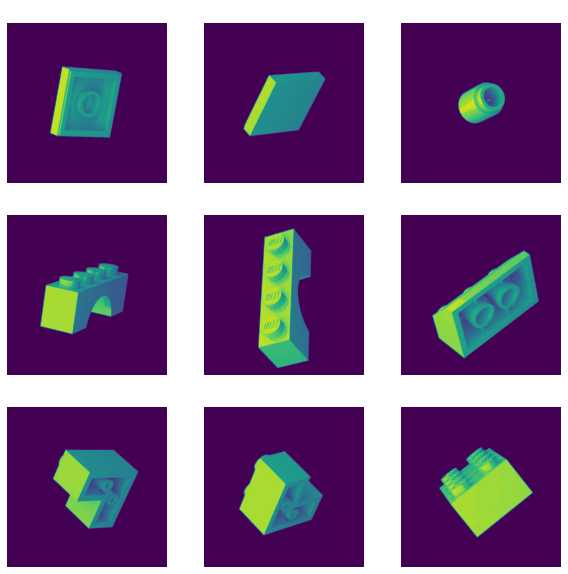

In [118]:
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(bricks[labels[i]], color='white')
        plt.axis('off')
        # plt.colorbar()

Step 2
## Build the Model
Optional ToDo: [Performance optimization](https://www.tensorflow.org/guide/data_performance)

In [135]:
AUTOTUNE = tf.data.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size = AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size = AUTOTUNE)

In [137]:
# normalization_layer = layers.Rescaling(1./255)

In [150]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape = (400, 400, 1)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2),  # doesn't seam to change much
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(len(bricks))
])

In [ ]:
learning_rate = 0.001
# ToDo: Add learning rate to model

In [151]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

Step 3
## Train the Model

In [152]:
epochs = 5

In [153]:
history = model.fit(
    training_data,
    validation_data = testing_data,
    epochs = epochs
)

Epoch 1/5
100/100 [==============================] - 118s 1s/step - loss: 1.1006 - accuracy: 0.6031 - val_loss: 0.7201 - val_accuracy: 0.7225
Epoch 2/5
100/100 [==============================] - 112s 1s/step - loss: 0.4856 - accuracy: 0.8306 - val_loss: 0.7278 - val_accuracy: 0.7487
Epoch 3/5
100/100 [==============================] - 106s 1s/step - loss: 0.2755 - accuracy: 0.9041 - val_loss: 0.7595 - val_accuracy: 0.7613
Epoch 4/5
100/100 [==============================] - 111s 1s/step - loss: 0.1683 - accuracy: 0.9441 - val_loss: 0.8936 - val_accuracy: 0.7437
Epoch 5/5
 77/100 [======================>.......] - ETA: 24s - loss: 0.0805 - accuracy: 0.9797

KeyboardInterrupt: 

Visualize training results:

In [148]:
training_accuracy = history.history['accuracy']
training_val_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
training_val_loss = history.history['val_loss']

epochs_range = range(epochs)

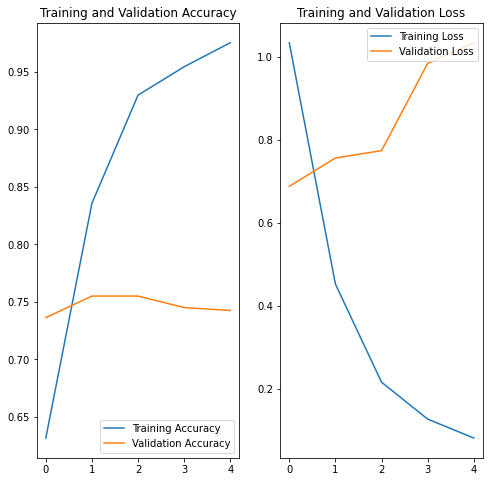

In [149]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, training_val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, training_val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()